In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from scipy.optimize import least_squares
from skimage.draw import draw
from scipy import interpolate
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

### Model the PSD
Base the model on the average PSD.

In [2]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 0.050*u.m, # not really useful but okay
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 100 * u.m,
             'khigh_ll': 1000 * u.m,
             'label': 'oap'}

fileloc = 'zygo_data/oaps/oap_coated/oap_avgPSD_centered_{0}CA_meters.fits'.format(str(opt_parms['ca']))
psd_fits = fits.open(fileloc)[0]
psd_avg = psd_fits.data * (u.nm*u.m)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = (psd_hdr['delta_k']/u.m)
opt_parms['diam_ca'] = (psd_hdr['diam_ca']*u.m)
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=avg_psd.k_min)
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 2min 36s, sys: 54.6 s, total: 3min 31s
Wall time: 3min 31s


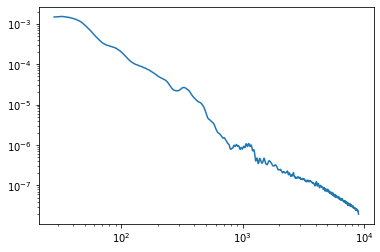

In [3]:
# Throw away some of the high-k ending data for better fitting
# The last data doesn't seem critical anyways
fin = len(avg_psd.k_radial)
offset = 120
avg_psd.k_radial = avg_psd.k_radial[0:fin-offset]
avg_psd.psd_radial_cal = avg_psd.psd_radial_cal[0:fin-offset]
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value)

In [4]:
%%time
ist = [0, 52, 400]
#iend = [30, 390]
iend = ist[1:]
iend.append(len(avg_psd.k_radial)-15)

sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
rms_sr = [0.000005*u.nm,0.000005*u.nm, avg_sr_rms]

psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
mdl_set = []
x0 = [[1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

CPU times: user 20.7 s, sys: 185 ms, total: 20.9 s
Wall time: 10.6 s


/home/jhen/XWCL/code/model_kit/model_kit/psd_functions.py:684: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


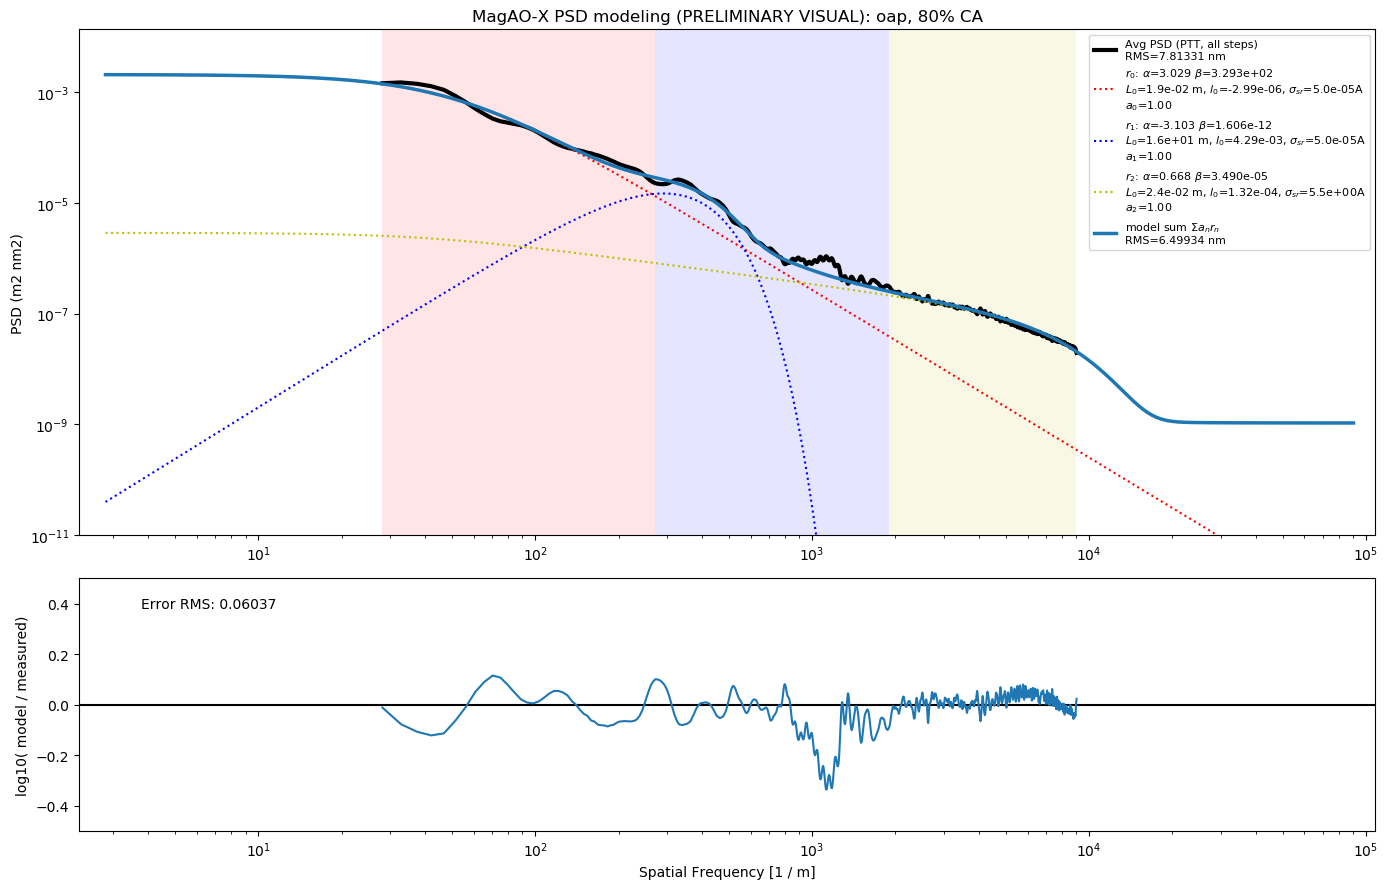

In [5]:
psd.plot_model2(mdl_set, ms_refit, avg_psd, opt_parms)

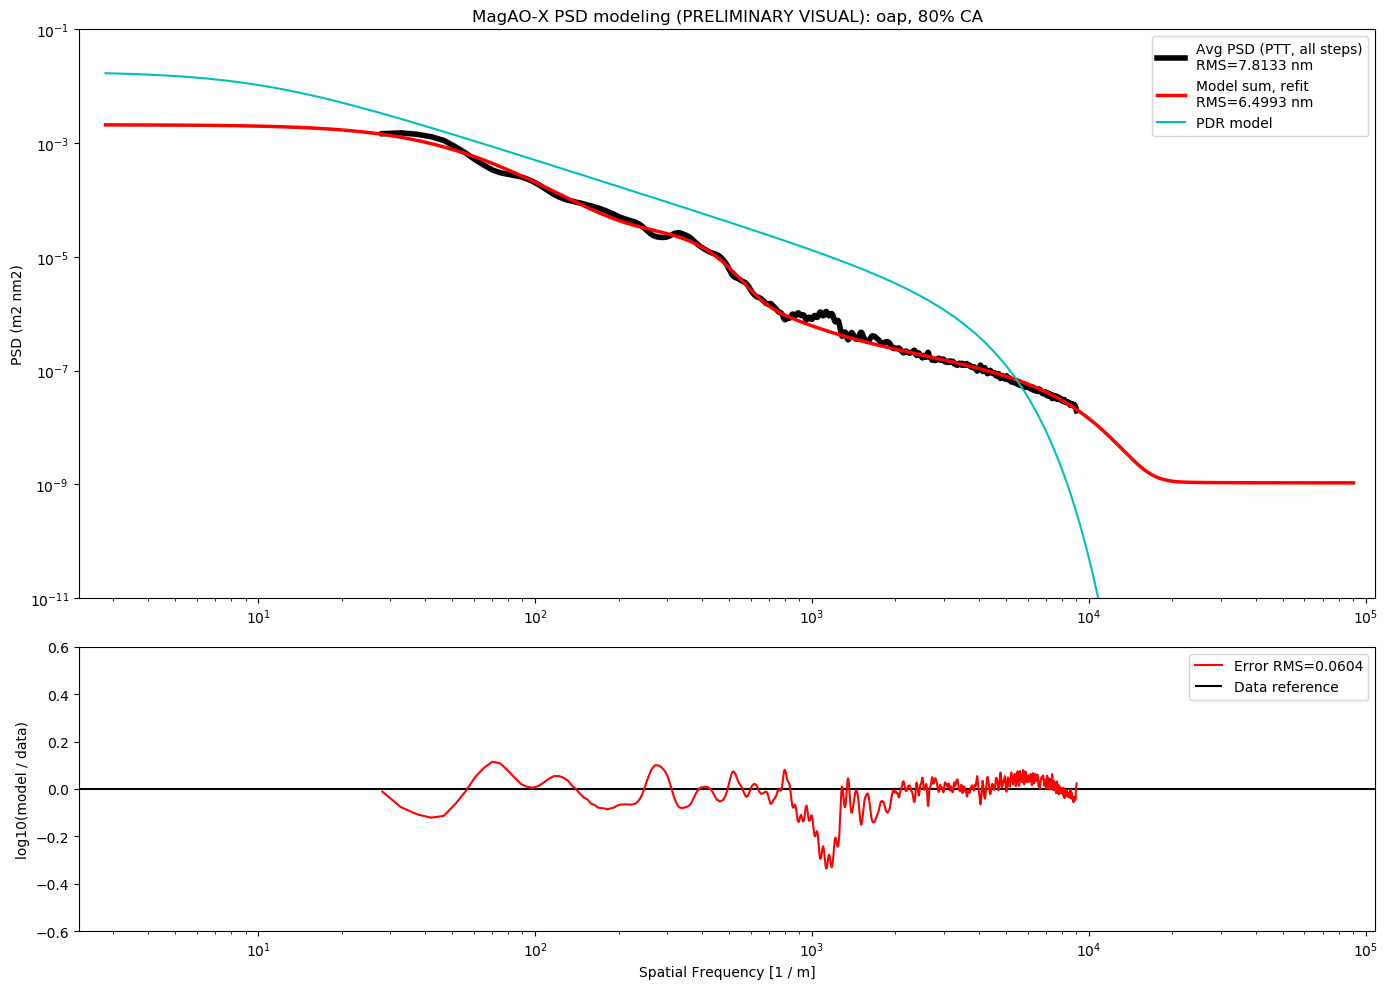

In [7]:
ap = 1.55
bp = 0.637 * (u.nm**2)/(u.m**(ap-2))
parm_pdr = [ap, bp, 0.1*u.m, 0.0003, 0*(u.nm*u.m)**2]
psd_pdr = psd.model_full(k=mdl_set[0].k_range, psd_parm=parm_pdr)

k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,10],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=4, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.loglog(k_range_mdl, psd_pdr.value, 'c', linewidth=1.5, label='PDR model')
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(top=1e-1, bottom=1e-11)
ax0.set_ylabel('PSD ({0})'.format(ms_refit.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): {0}, {1}% CA'.format(opt_parms['label'],opt_parms['ca']))

ax1 = plt.subplot(gs[1])
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k', label='Data reference')
ax1.semilogx(k_radial, ms_refit.error, 'r', label='Error RMS={0:.4f}'.format(ms_refit.error_rms))
ax1.legend(prop={'size':10})
ax1.set_ylim(top=0.6, bottom=-0.6)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / data)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms_refit.k_radial_data.unit))

plt.tight_layout()

In [8]:
# Save the PSD values into a pickle to access later
psd_dict = {'psd_oap': ms_refit.psd_parm,
            'psd_oap_weight': psd_weight}

# save the directory as a pickle
import pickle
filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_oap.pickle'
with open(filename,'wb') as psd_parameter_file:
    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

In [9]:
objects = []
with (open("/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_oap.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
            
objects

[{'psd_oap': [[3.0288224634512853,
    <Quantity 329.34016876 nm2 / m(1.0288224634512853)>,
    <Quantity 0.01924766 m>,
    -2.9860110970189987e-06,
    <Quantity 8.66369955e-20 m2 nm2>],
   [-3.1025409448384367,
    <Quantity 1.60571879e-12 m(5.102540944838436) nm2>,
    <Quantity 15.74916845 m>,
    0.004291992175215349,
    <Quantity 8.66369955e-20 m2 nm2>],
   [0.667789687284985,
    <Quantity 3.49006902e-05 m(1.332210312715015) nm2>,
    <Quantity 0.02393568 m>,
    0.00013229785639507765,
    <Quantity 1.05785937e-09 m2 nm2>]],
  'psd_oap_weight': [1.0, 1.0, 1.0]}]

Text(0.5, 1.0, 'PSD oap, RMS=7.0130 nm, PV=60.74 nm')

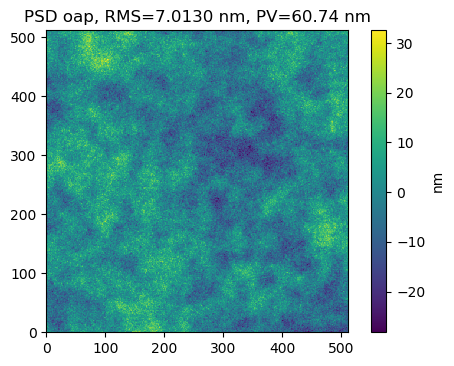

In [10]:
psd_weight_oap = [1.0, 1.0, 1.0]

screen_size = 2048
seed = 5 #123456
npix = 512
diam = 0.02587875072 * u.m
surf_unit = u.nm

def rms(opd):
    return np.sqrt(np.mean(np.square(opd)))

def pv(opd):
    return np.amax(opd) - np.amin(opd)

import poppy
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=ms_refit.psd_parm, psd_weight=psd_weight_oap,
                                seed=seed, apply_reflection=False, screen_size=screen_size,
                                wfe=7.013*u.nm)
psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surf_unit)
psd_rms = rms(psd_opd)
psd_pv = pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.value, origin='lower')
plt.colorbar().set_label(psd_opd.unit)
plt.title('PSD oap, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))